In [352]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import glob
import imageio
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import PIL
import time
from IPython import display

img_dim1 = 36
img_dim2 = 36

# Load and prepare dataset
class load_data(Dataset):
  def __init__(self, data_dir):
    self.data_dir = data_dir
    self.transform = transforms.Compose([
      transforms.Resize((img_dim1, img_dim2)),   # Resize images to a fixed size
      transforms.ToTensor(),         # Convert images to PyTorch tensors
      transforms.Normalize(mean=[0.5], std=[0.5]),
      ])
    self.image_files = [f for f in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, f))]

  def __len__(self):
    return len(self.image_files)

  def __getitem__(self, idx):
    img_name = os.path.join(self.data_dir, self.image_files[idx])
    # image = PIL.Image.open(img_name)
    image = PIL.Image.open(img_name)
    if self.transform:
      image = self.transform(image)

    # print(image.shape)

    return image


BATCH_SIZE = 130

tr_data_path = "train_data"

# Load data
dataset = load_data(tr_data_path)
tr_data = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# remove the images from images folder
!rm images/*

In [353]:
import random

seed = random.randint(1, 10000)
print(seed)

random.seed(seed)
torch.manual_seed(seed)

3570


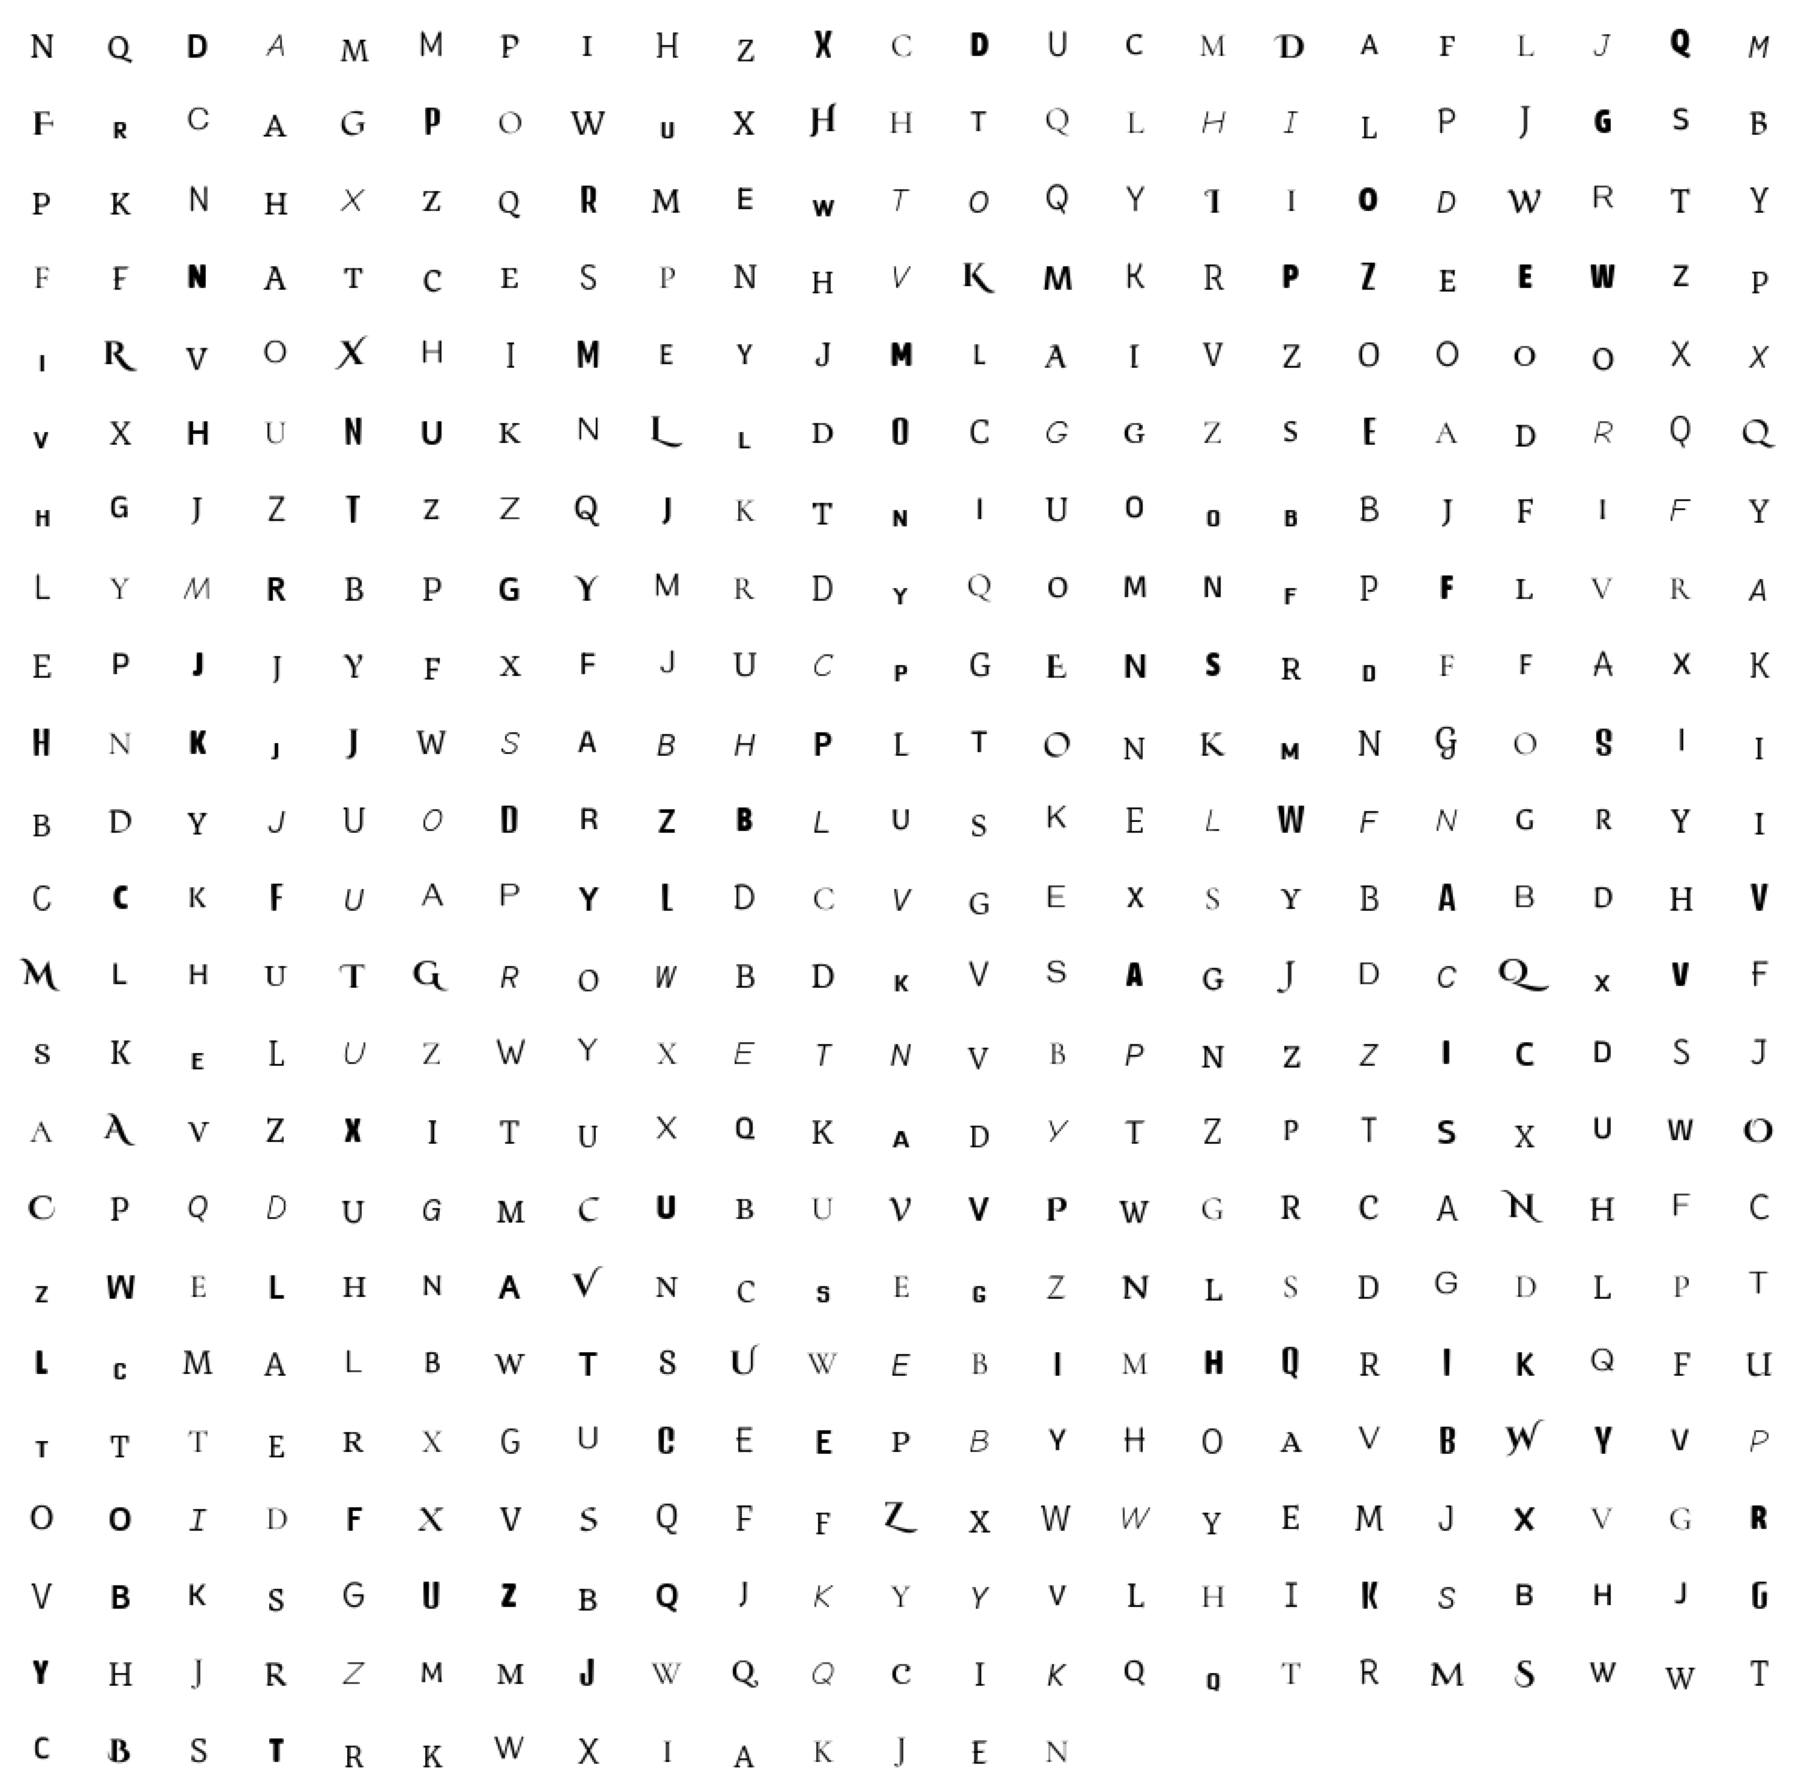

In [354]:
fig = plt.figure(figsize=(23, 23))

for i, img in enumerate(dataset):
  # print(img, img.shape)
  plt.subplot(23, 23, i + 1)
  plt.imshow((img[0, :, :] * 0.5 + 0.5).numpy(), cmap='gray')
  plt.axis('off')
plt.grid(True, linewidth=2, color='gray')
plt.show()


In [355]:
# Generator
class Generator(nn.Module):
  def __init__(self, in_size, hid_size, out_size):
    super(Generator, self).__init__()
    # nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1, padding_mode='zeros', device=None, dtype=None)
    # nn.BatchNorm2d(num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, device=None, dtype=None)
    # nn.LeakyReLU(negative_slope=0.01, inplace=False)
    self.main = nn.Sequential(
        nn.ConvTranspose2d(in_size, hid_size*8, 4, 1, 0, bias=True),
        nn.BatchNorm2d(hid_size*8),
        nn.ReLU(True),

        nn.ConvTranspose2d(hid_size*8, hid_size*4, 3, 1, 0, bias=True),
        nn.BatchNorm2d(hid_size*4),
        nn.ReLU(True),

        nn.ConvTranspose2d(hid_size*4, hid_size*2, 3, 1, 0, bias=True),
        nn.BatchNorm2d(hid_size*2),
        nn.ReLU(True),

        nn.ConvTranspose2d(hid_size*2, hid_size, 3, 1, 0, bias=True),
        # nn.BatchNorm2d(hid_size),
        # nn.ReLU(True),

        nn.ConvTranspose2d(hid_size, out_size, 2, 2, 0, bias=True),
        nn.Tanh()
      )

  def forward(self, input):
    # print("Generator", input.shape)
    return self.main(input)

In [356]:
# Discriminator
# yet to add dropout
class Discriminator(nn.Module):
  def __init__(self, in_size, out_size):
    super(Discriminator, self).__init__()
    self.main = nn.Sequential(
      nn.Conv2d(in_size, out_size, 4, 2, 1, bias=True),
      nn.LeakyReLU(0.2, inplace=True),
      nn.Dropout(0.3),

      nn.Conv2d(out_size, out_size * 2, 4, 2, 1, bias=True),
      nn.BatchNorm2d(out_size * 2),
      nn.LeakyReLU(0.2, inplace=True),
      nn.Dropout(0.3),

      nn.Conv2d(out_size * 2, out_size * 4, 4, 2, 1, bias=True),
      nn.BatchNorm2d(out_size * 4),
      nn.LeakyReLU(0.2, inplace=True),
      nn.Dropout(0.3),

      nn.Conv2d(out_size * 4, 1, 4, 1, 0, bias=True),
      nn.Sigmoid()
    )

  def forward(self, input):
    return self.main(input)

In [357]:
in_size_gen = 128
hid_size_gen = 64
out_size_gen = 1

in_size_dis = 1
out_size_dis = 64

beta1 = 0.5
lr = 0.005

nnG = Generator(in_size_gen, hid_size_gen, out_size_gen)   # fill sizes
nnD = Discriminator(in_size_dis, out_size_dis) # fill sizes

# Loss and optimizers
cross_entropy = nn.BCELoss()

generator_optimizer = optim.Adam(nnG.parameters(), lr=lr, betas=(beta1, 0.999))
discriminator_optimizer = optim.Adam(nnD.parameters(), lr=lr, betas=(beta1, 0.999))

def discriminator_loss(real_output, fake_output):
  real_labels = torch.ones_like(real_output)  # since discriminator should output 1 for all real images
  fake_labels = torch.zeros_like(fake_output) # since discriminator should output 0 for all fake images

  # Calculate the loss for real and fake data
  real_loss = cross_entropy(real_output, real_labels)
  fake_loss = cross_entropy(fake_output, fake_labels)

  # Total discriminator loss
  total_loss = real_loss + fake_loss

  return total_loss

def generator_loss(fake_output):
  return cross_entropy(fake_output, torch.ones_like(fake_output))


torch.Size([1, 1, 36, 36])


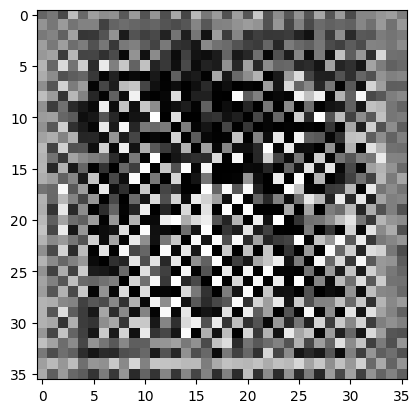

In [358]:
# Test generator
noise_dim1 = 9
noise_dim2 = 9
noise = torch.randn(1, in_size_gen, noise_dim1, noise_dim2)
generated_image = nnG(noise)
print(generated_image.shape)
g_img = generated_image.detach().numpy()
plt.imshow(g_img[0, 0, :, :], cmap='gray')

In [359]:
# Save checkpoints
def save_model():
  checkpoint_dir = './training_checkpoints'
  checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
  checkpoint = torch.save(generator_optimizer=generator_optimizer.state_dict(),
                                  discriminator_optimizer=discriminator_optimizer.state_dict(),
                                  generator=nnG.state_dict(),
                                  discriminator=nnD.state_dict())


def train_step(images):
  noise = torch.randn(BATCH_SIZE, in_size_gen, noise_dim1, noise_dim2)

  # Zero the gradients for both generator and discriminator
  nnG.zero_grad()
  nnD.zero_grad()

  # Generate fake images and compute losses
  generated_images = nnG(noise)

  # print("tstep")
  # print(noise.shape)
  # print(generated_images.shape)
  # print('images.shape', images.shape)
  # print('images', images)

  real_output = nnD(images)
  fake_output = nnD(generated_images)

  # print('real shape', real_output.shape)
  # print(real_output)
  # print(fake_ouput)

  gen_loss = generator_loss(fake_output)
  dis_loss = discriminator_loss(real_output, fake_output)

  # Backpropagate and update weights
  gen_loss.backward(retain_graph=True)
  dis_loss.backward(retain_graph=True)

  # gen_loss.backward()
  # dis_loss.backward()

  generator_optimizer.step()
  discriminator_optimizer.step()

  return gen_loss.item(), dis_loss.item()


In [360]:
# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
num_examples_to_generate = 64
test_noise = torch.randn(num_examples_to_generate, in_size_gen, noise_dim1, noise_dim2)

plt_rows = 8
plt_cols = 8


def train(dataset, epochs):
    g_losses = []
    d_losses = []

    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
          # print(image_batch.shape)
          g_loss, d_loss = train_step(image_batch)

          g_losses.append(g_loss)
          d_losses.append(d_loss)

        # Produce images for display as you go
        display.clear_output(wait=True)
        generate_and_save_images(epoch + 1, test_noise)

        # # Save the model every 15 epochs (checkpoint is assumed to be a PyTorch model checkpoint)
        # if (epoch + 1) % 15 == 0:
        #     save_model()

        print(f'Time for epoch {epoch + 1} is {time.time() - start:.2f} sec')

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(epochs, test_noise)

    return (g_losses, d_losses)

In [361]:
plt_rows = 8
plt_cols = 8

# Generate and Save images
def generate_and_save_images(epoch, test_noise):
    # Set the generator in evaluation mode
    # nnG.eval()

    with torch.no_grad():
      # print("gsi - ", epoch)
      # print(test_noise.shape)
      generated_images = nnG(test_noise).detach().cpu()
      # print(generated_images.shape)

    # nnG.train()  # Set the generator back to training mode if needed

    fig = plt.figure(figsize=(plt_rows, plt_cols))

    for i in range(generated_images.size(0)):
      plt.subplot(plt_rows, plt_cols, i + 1)
      plt.imshow((generated_images[i, 0] * 0.5 + 0.5).numpy(), cmap='gray')
      plt.axis('off')

    output_dir = "images"
    plt.savefig(os.path.join(output_dir, 'image_at_epoch_{:04d}.png'.format(epoch)))
    plt.show()

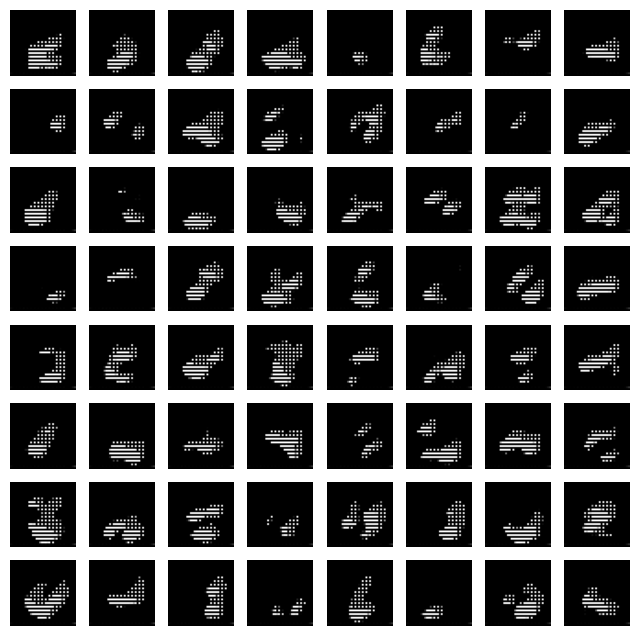

Time for epoch 9 is 31.32 sec


In [ ]:
# Training Loop
EPOCHS=50

g_losses, d_losses = train(tr_data, EPOCHS)
# display.clear_output(wait=True)


In [ ]:
from datetime import datetime

now = datetime.now()
dt_string = now.strftime("%d-%m-%Y %H:%M:%S")

# print(g_losses, d_losses)
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Losses Over Time")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.plot(g_losses, label="Generator Loss")
plt.plot(d_losses, label="Discriminator Loss")
plt.legend()
plt.grid(True)
img_name = 'loss_plt_' + dt_string + '.png'
plt.savefig(os.path.join('graph', img_name))

plt.show()